In [3]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import geopandas as gpd
from shapely.geometry import Point, mapping
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import cityImage as ci

In [4]:
city_name = 'Muenster'
epsg = 25832
crs = 'EPSG:'+str(epsg)

### Download from OSM the drive network

Choose between the following methods:
* `OSMplace`, provide an OSM place name (e.g. City).
* `polygon`, provide an WGS polygon of the case-study area.
* `distance_from_address`, provide a precise address and define parameter `distance` (which is otherwise not necessary)

In [4]:
place = 'Muenster, Germany'
download_method = 'OSMplace'
distance = None

nodes_graph, edges_graph = ci.get_network_fromOSM(place, download_method, 'drive', epsg, distance = distance)
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_disconnected_islands = True,
                            self_loops = True, same_uv_edges = True)

# saving
saving_path = 'Outputs/'+city_name+'/entireNetwork/'
nodes_graph.to_file(saving_path+city_name+"_nodes.shp", driver='ESRI Shapefile')
edges_graph.to_file(saving_path+city_name+"_edges.shp", driver='ESRI Shapefile')

# Creating and saving the dual geodataframes
nodesDual_graph, edgesDual_graph = ci.dual_gdf(nodes_graph, edges_graph, epsg)
nodesDual_graph.drop('intersecting', axis = 1).to_file(saving_path+city_name+"_nodesDual.shp", driver='ESRI Shapefile')
edgesDual_graph.to_file(saving_path+city_name+"_edgesDual.shp", driver='ESRI Shapefile')

### Load from local path (when already processed the network)

In [9]:
input_path = 'Outputs/'+city_name+'/entireNetwork/'

nodes_graph = gpd.read_file(input_path+city_name+'_nodes.shp')
edges_graph = gpd.read_file(input_path+city_name+'_edges.shp')
nodesDual_graph = gpd.read_file(input_path+city_name+'_nodesDual.shp')
edgesDual_graph = gpd.read_file(input_path+city_name+'_edgesDual.shp')

try:
    nodes_graph, edges_graph = nodes_graph.to_crs(epsg=epsg), edges_graph.to_crs(epsg=epsg)
    nodesDual_graph, edgesDual_graph = nodesDual_graph.to_crs(epsg=epsg), edgesDual_graph.to_crs(epsg=epsg)
except:
    nodes_graph.crs, edges_graph.crs = crs, crs
    nodesDual_graph.crs, edgesDual_graph.crs = crs, crs
    
nodes_graph.index, edges_graph.index, nodesDual_graph.index = nodes_graph.nodeID, edges_graph.edgeID, nodesDual_graph.edgeID
nodes_graph.index.name, edges_graph.index.name, nodesDual_graph.index.name = None, None, None

### Visualise 

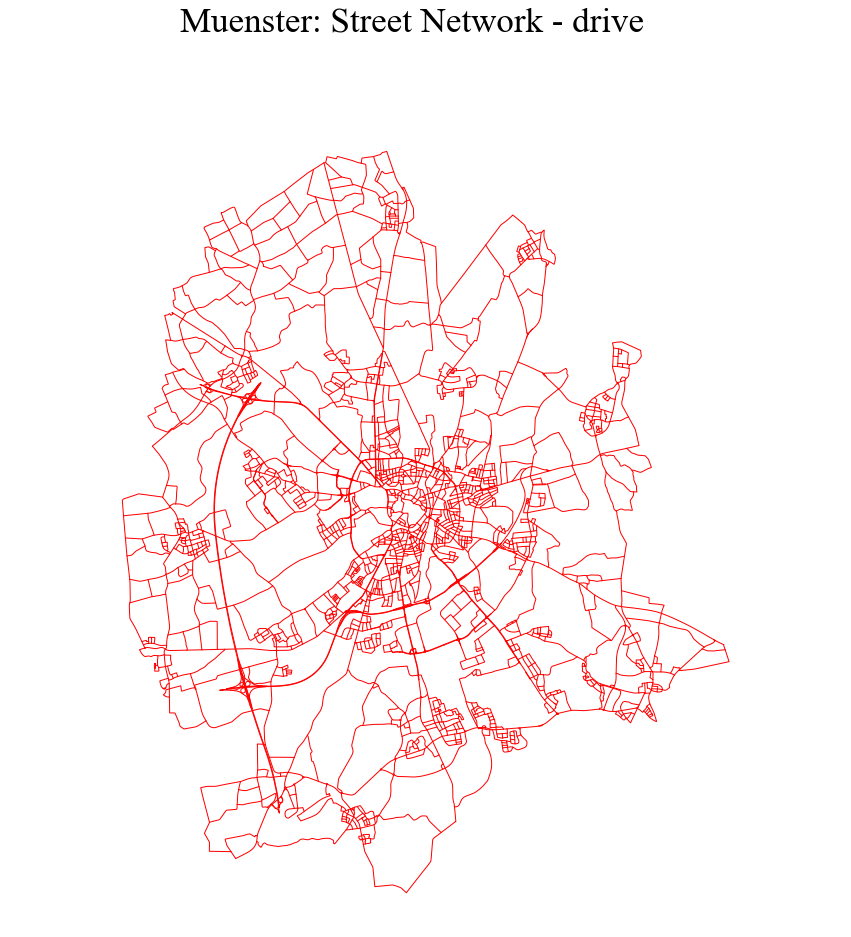

In [7]:
fig = ci.plot_gdf(edges_graph, scheme = None, black_background = False, fig_size = 15, title = 
                  city_name+': Street Network - drive')

## District identification

In [10]:
# creating dual_graph
dual_graph = ci.dual_graph_fromGDF(nodesDual_graph, edgesDual_graph)

Different weights can be used to extract the partitions. `None` indicates that no weights will be used 
(only topological relationships will matter). The function returns a GeoDataFrame with partitions assigned to edges,
with column named as `p_name_weight` (e.g. `p_length`).

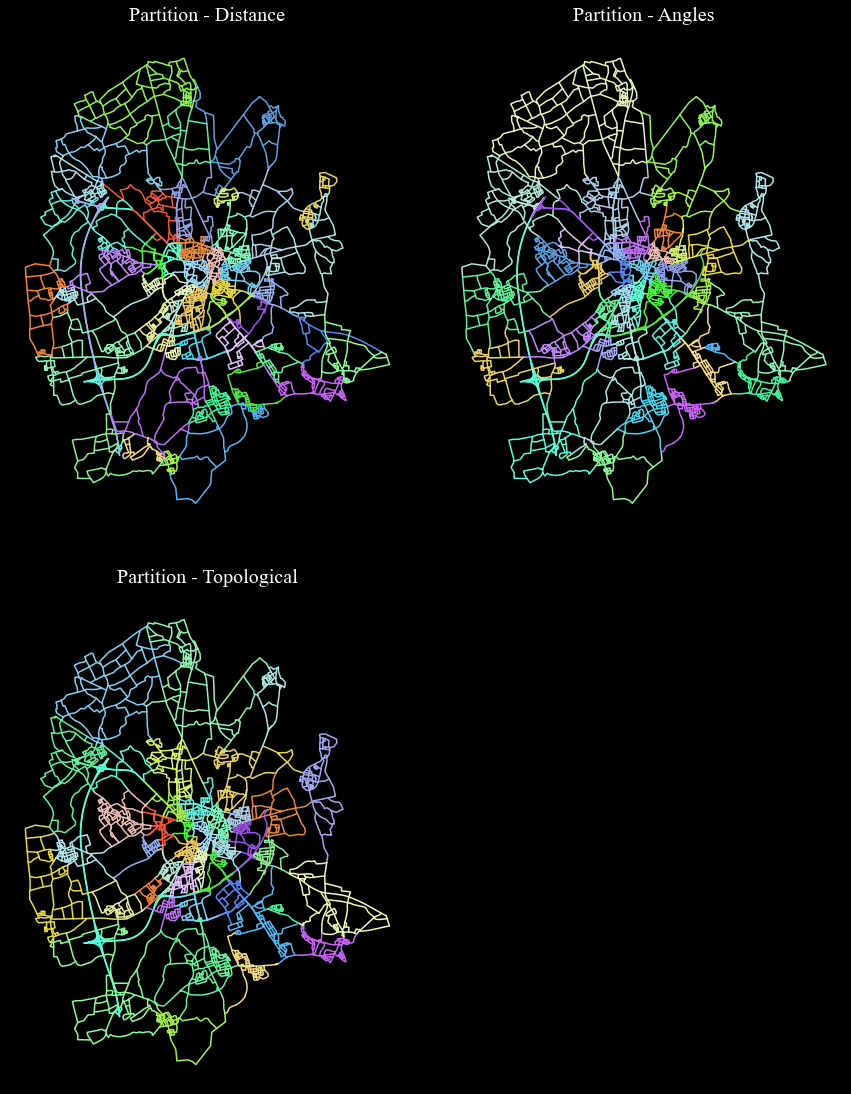

In [22]:
weights = ['length', 'rad', None]
districts = edges_graph.copy()
for weight in weights:
    districts = ci.identify_regions(dual_graph, districts, weight = weight)
    
# visualising
columns = ['p_length','p_rad', 'p_topo']
titles = ['Partition - Distance', 'Partition - Angles', 'Partition - Topological']

nlabels = max([len(districts[column].unique()) for column in columns])
cmap = ci.rand_cmap(nlabels = nlabels, type_color='bright')
fig = ci.plot_gdf_grid(districts, columns = columns, titles = titles, lw = 1.5, cmap = cmap, black_background = True, 
                  legend = False, fig_size = 15)

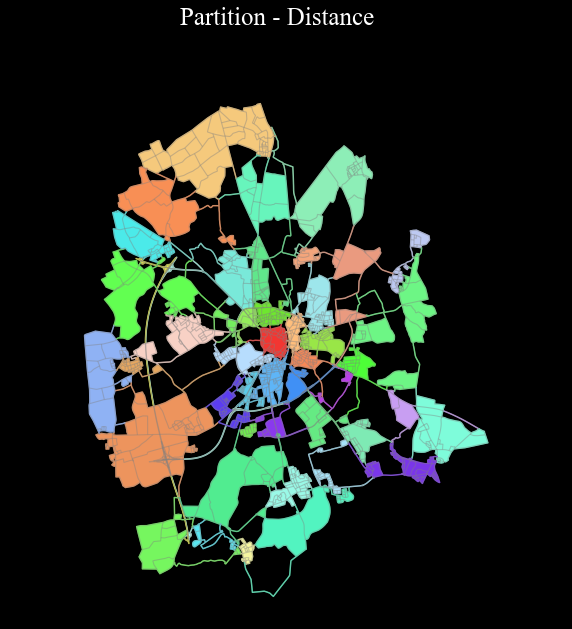

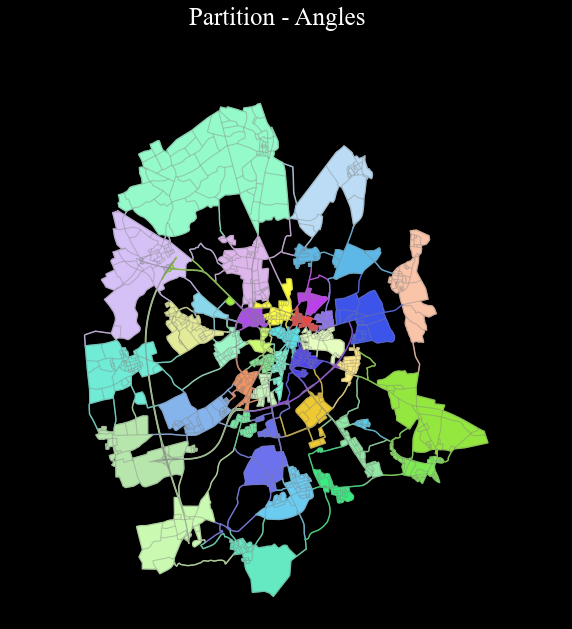

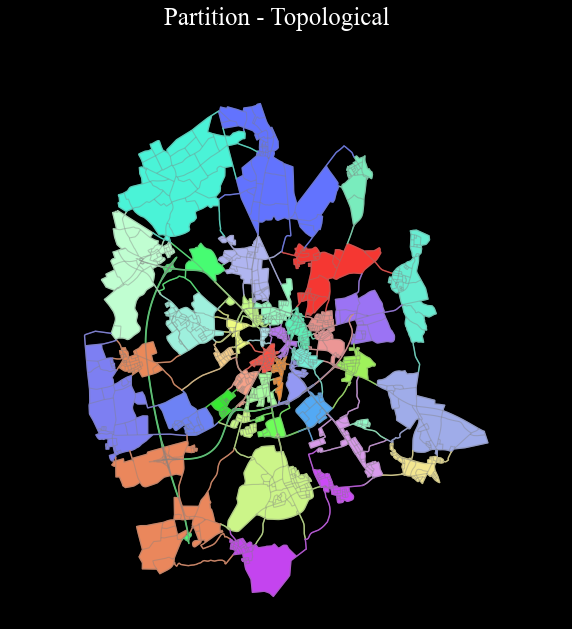

In [27]:
for n, column in enumerate(columns):
    cmap = ci.rand_cmap(nlabels = len(districts[column].unique()), type_color='bright')
    partitions = ci.polygonise_partitions(districts, column, convex_hull = False)
    ci.plot_gdf(partitions, column = column, cmap = cmap, title =  titles[n], black_background = True,  fig_size = 10,
               gdf_base_map = districts, base_map_color = 'grey', base_map_zorder = 1)

In [29]:
# saving
saving_path = 'Outputs/'+city_name+'/entireNetwork/'
districts.to_file(saving_path+city_name+"_edges.shp", driver='ESRI Shapefile')

## Case-study area (pedestrian walkable network)
### It should be ottained via notebook 01-Nodes_paths_web

In [89]:
nodes_graph_ped

,nodeID,x,y,height,geometry,gateway,p_length,district
12,12,405767.231,5756902.536,2.000,POINT (405767.231 5756902.536),0,2,2
13,13,405840.629,5756859.733,2.000,POINT (405840.629 5756859.733),0,2,2
14,14,405890.085,5756945.802,2.000,POINT (405890.085 5756945.802),0,2,2
21,21,405757.024,5757023.984,2.000,POINT (405757.024 5757023.984),0,2,2
23,23,406011.184,5757618.801,2.000,POINT (406011.184 5757618.801),0,4,4
...,...,...,...,...,...,...,...,...
12154,12154,405970.673,5756412.823,NaN,POINT (405970.673 5756412.823),0,2,2
12158,12158,405925.774,5756558.585,NaN,POINT (405925.774 5756558.585),0,2,2
12055,12055,404442.313,5759407.508,NaN,POINT (404442.313 5759407.508),0,5,5
12101,12101,406239.853,5756215.058,NaN,POINT (406239.853 5756215.058),0,8,8


In [30]:
input_path = 'Outputs/'+city_name+'/'
nodes_graph_ped = gpd.read_file(input_path+city_name+'_nodes.shp')
edges_graph_ped = gpd.read_file(input_path+city_name+'_edges.shp')

try:
    nodes_graph_ped, edges_graph_ped = nodes_graph_ped.to_crs(epsg=epsg), edges_graph_ped.to_crs(epsg=epsg)
except:
    nodes_graph_ped.crs, edges_graph_ped.crs = crs, crs

nodes_graph_ped.index, edges_graph_ped.index  = nodes_graph_ped.nodeID, edges_graph_ped.edgeID
nodes_graph_ped.index.name, edges_graph_ped.index.name  = None, None

### Otherwise, get it from OSM:

Choose between the following methods:
* `OSMplace`, provide an OSM place name (e.g. City).
* `polygon`, provide an WGS polygon of the case-study area.
* `distance_from_address`, provide a precise address and define parameter `distance` (which is otherwise not necessary)

In [ ]:
place = 'Domplatz, Muenster, Germany' ## must be different from the area used for the drive network
download_method = 'OSMplace'
distance = 2500

nodes_graph_ped, edges_graph_ped = ci.get_network_fromOSM(place, download_method, 'walk', epsg, distance = distance)
nodes_graph_ped, edges_graph_ped = ci.clean_network(nodes_graph_ped, edges_graph_ped, dead_ends = True, 
                                remove_disconnected_islands = True, self_loops = True, same_uv_edges = True)

### Option 2 - Load it from local path

### Visualise 

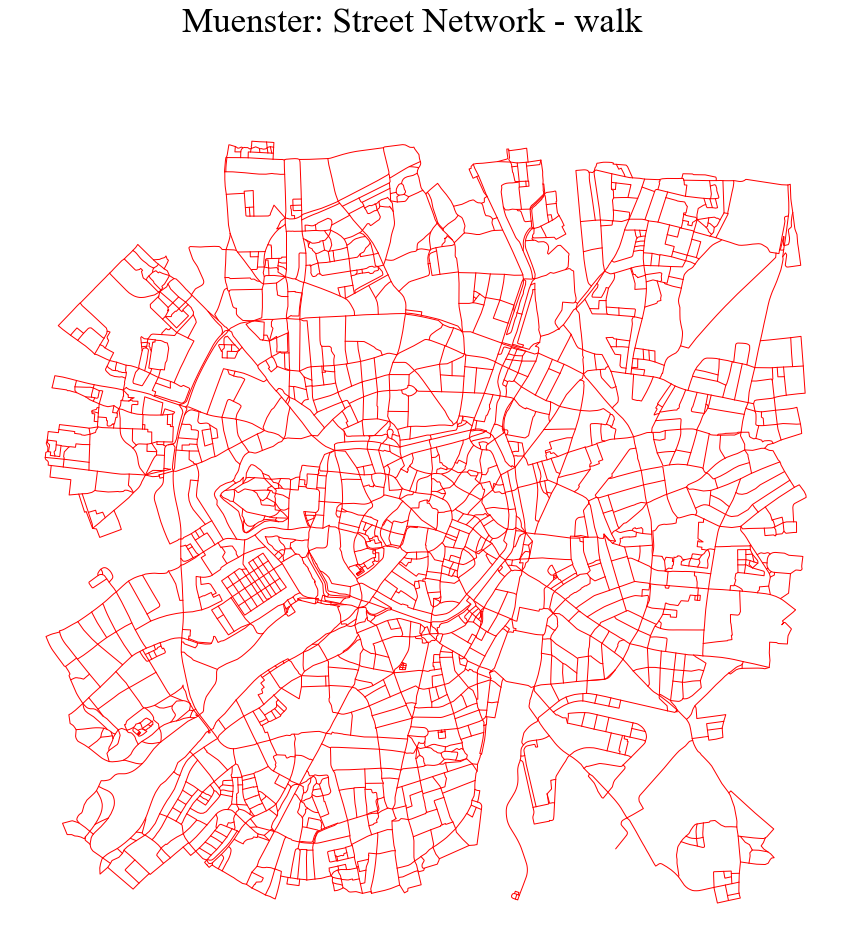

In [32]:
fig = ci.plot_gdf(edges_graph_ped, black_background = False, fig_size = 15, title = city_name+': Street Network - walk')

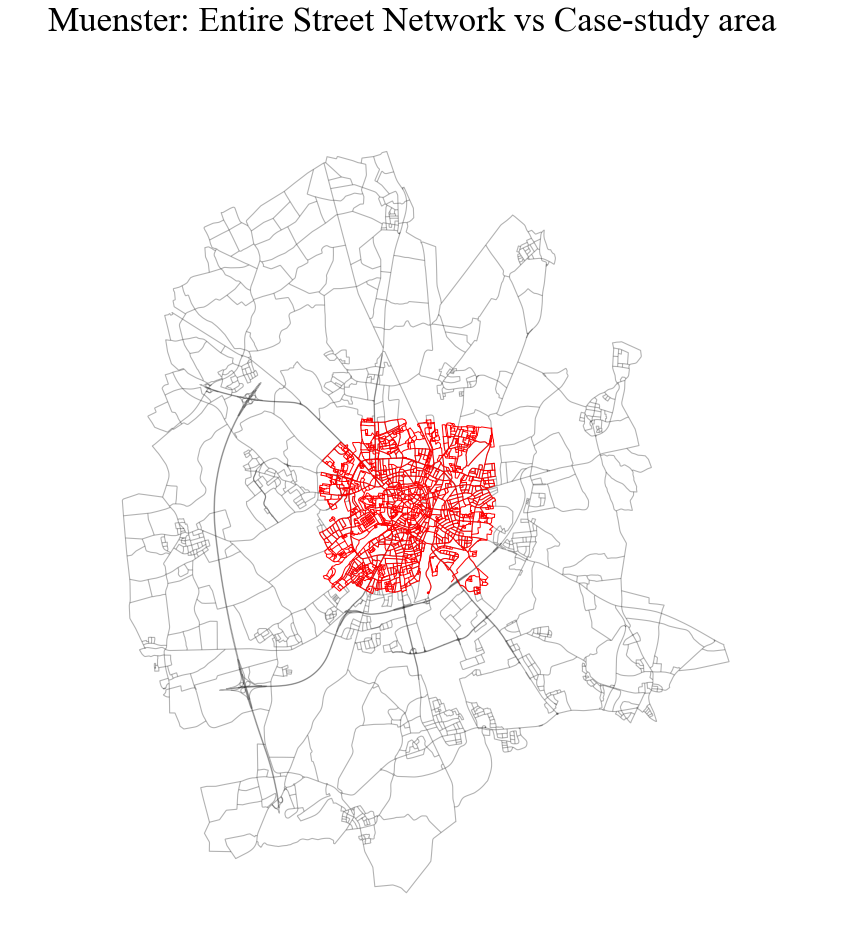

In [33]:
fig = ci.plot_gdf(edges_graph_ped, scheme = None,  black_background = False, fig_size = 15, title = 
              city_name+': Entire Street Network vs Case-study area',
             gdf_base_map = edges_graph, base_map_color = 'black', base_map_alpha = 0.3)

## Assign nodes and edges in the pedestrian network to a partition

In [77]:
# choose type of partition you want to use
column = 'p_length'
min_size_district = 10

In [81]:
dc = dict(districts[column].value_counts())

## ignore small portions
to_ignore = {k: v for k, v in dc.items() if v <= min_size_district} 
tmp = districts[~((districts[column].isin(to_ignore))| (districts[column] == 999999))].copy()

partitions = ci.polygonise_partitions(tmp, column)
nodes_graph_ped = ci.district_to_nodes_from_polygons(nodes_graph_ped, partitions, column)
nodes_graph_ped[column] = nodes_graph_ped[column].astype(int)

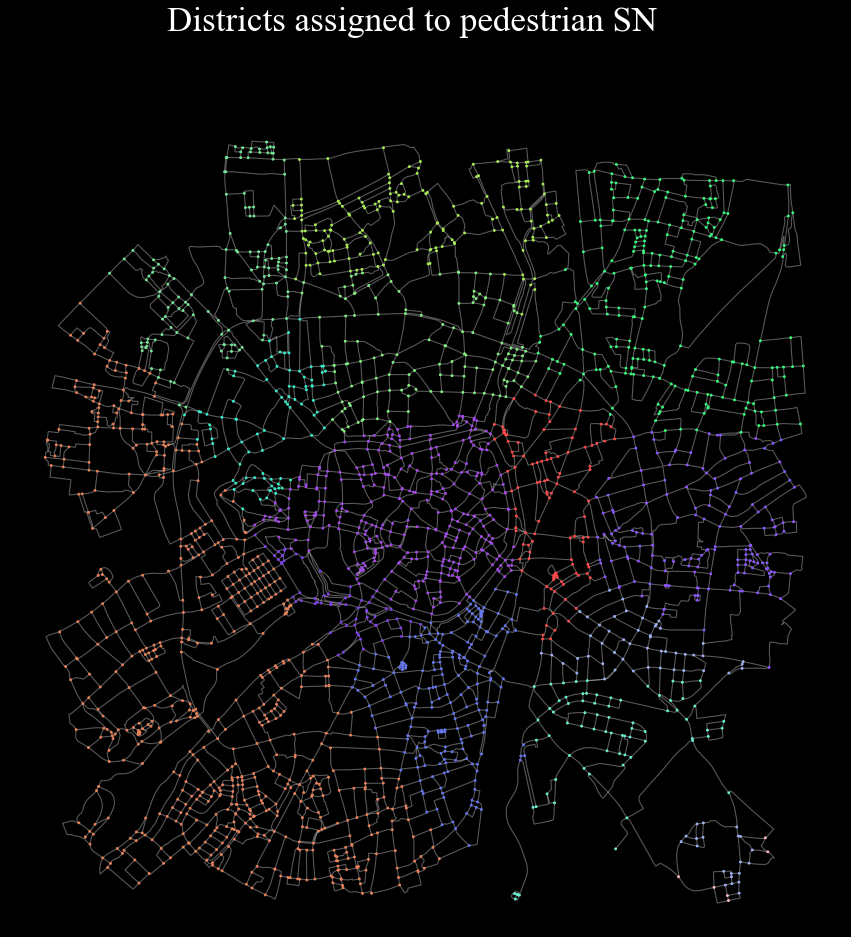

In [61]:
# visualisation
cmap = ci.rand_cmap(nlabels = len(nodes_graph_ped[column].unique()), type_color='bright')
fig = ci.plot_gdf(nodes_graph_ped, column = column, title = 'Districts assigned to pedestrian SN', cmap = cmap, ms = 3.5,
              gdf_base_map = edges_graph_ped, base_map_color = 'white', base_map_alpha = 0.35,
               black_background = True, legend = False, fig_size = 15)

In [82]:
# fixing disconnected districts and assigning nodes to existing connected districts

nodes_graph_ped = ci.amend_nodes_membership(nodes_graph_ped, edges_graph_ped, column, min_size_district)
    
# assign gateways
nodes_graph_ped = ci.find_gateways(nodes_graph_ped, edges_graph_ped, column)

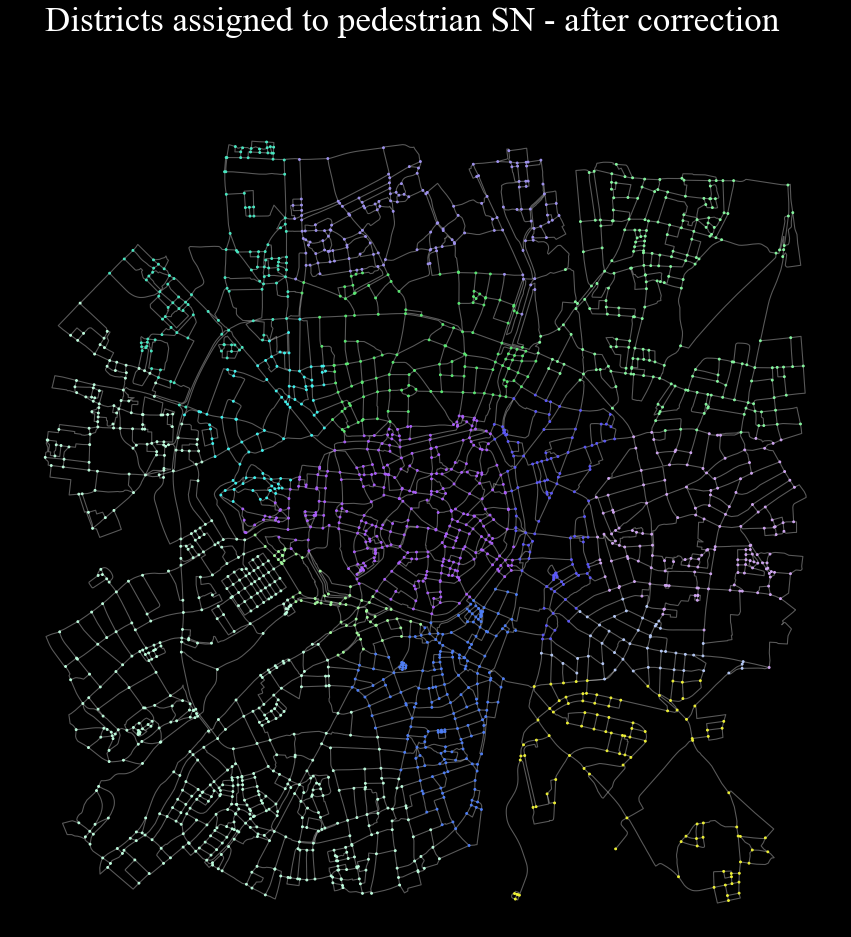

In [83]:
# visualise the final division
cmap = ci.rand_cmap(nlabels = len(nodes_graph_ped[column].unique()), type_color='bright')
fig = ci.plot_gdf(nodes_graph_ped, column = column, title = 'Districts assigned to pedestrian SN - after correction', 
               cmap = cmap, ms = 3.5, gdf_base_map = edges_graph_ped, base_map_color = 'white', base_map_alpha = 0.35,
               black_background = True, legend = False, fig_size = 15)

In [86]:
nodes_graph_ped['district'] = nodes_graph_ped[column].astype(int)

In [88]:
# saving
saving_path = 'Outputs/'+city_name+'/'
nodes_graph_ped.to_file(saving_path+city_name+"_nodes.shp", driver='ESRI Shapefile')
edges_graph_ped.to_file(saving_path+city_name+"_edges.shp", driver='ESRI Shapefile')